# Learning Goals

The goal of this assignment is to develop an understanding of how the brain performs computations at the neuronal level. To do so, you will develop several models of a spiking neuron. By the end of this assignment, you should a) be comfortable with developing models of spiking neurons at different levels of abstraction, from the biologically plausible H-H model to the phenomenological LIF model; b) understand how neurons use their firing rate to represent continuous-valued information; and c) understand the trade-offs involved in spike-based information representation. 

Let's first import all the libraries required for this assignment

In [1]:
import math
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms

# Question 1: The Hodgkin Huxley Neuron
## 1a. 
We will start by implementing the different computational models of a spiking neuron, with the aim of understanding the differences between the different models. We will start with one of the earliest, yet one of the most biologically faithful models of a neuron - The Hodgkin-Huxley (HH) model. Below is the class definition of an HH neuron. Your first task is to fill the different components required to simulate an HH neuron. 

In [2]:
class HodgkinHuxley():
    """Implementation of Hodgkin Huxley Model"""
    def __init__(self, C_m, g_Na, g_K, g_L, E_Na, E_K, E_L, T, dt):
        """
        :param C_m: membrane capacitance in uF/cm^2
        :param g_Na: Sodium conductance in mS/cm^2
        :param g_K: Potassium conductance in ms/cm^2
        :param g_L: Leak maximum conductance
        :param E_Na: Sodium Nernst reversal potential in mV
        :param E_K: Potassium Nernst reversal potential in mV
        :param E_L: Leak Nernst reversal potential in mV
        :param T: Simulation timesteps
        :param dt: Integration time 
        
        This function is complete. You do not need to do anything here.
        """
        self.C_m = C_m 
        self.g_Na = g_Na 
        self.g_K = g_K
        self.g_L = g_L
        self.E_Na = E_Na
        self.E_K = E_K
        self.E_L = E_L
        self.T = T
        self.dt = dt
        self.t = np.arange(0, self.T, self.dt) #time to integrate over
    
    def alpha_m(self, V):
        """
        Channel gating kinetics
        :param V: membrane voltage
        :return: alpha_m
        
        Fill in the equation for alpha_m
        """
        return (0.1*(V + 40)) / (1 - math.exp(-(V + 40)/10))
    
    def beta_m(self, V):
        """
        Channel gating kinetics
        :param V: membrane voltage
        :return: beta_m
        
        Fill in the equation for beta_m
        """
        return 4*math.exp(-(V + 65)/18)
    
    def alpha_h(self, V):
        """
        Channel gating kinetics
        :param V: membrane voltage
        :return: alpha_h
        
        Fill in the equation for alpha_h
        """
        return 0.07*math.exp(-(V + 65)/20)
    
    def beta_h(self, V):
        """
        Channel gating kinetics
        :param V: membrane voltage
        :return: beta_h
        
        Fill in the equation for beta_h
        """
        return 1/(1 + math.exp(-(V + 35)/10))
    
    def alpha_n(self, V):
        """
        Channel gating kinetics
        :param V: membrane voltage
        :return: alpha_n
        
        Fill in the equation for alpha_n
        """
        return (0.01*(V + 55)) / (1 - math.exp(-(V + 55)/10))
    
    def beta_n(self, V):
        """
        Channel gating kinetics
        :param V: membrane voltage
        :return: beta_n
        
        Fill in the equation for beta_n
        """
        return 0.125*math.exp(-(V + 65)/80)
    
    def I_Na(self, V, m, h):
        """
        Membrane Sodium current
        :param V: membrane voltage
        :param m: gating variable m
        :param h: gating variable h
        :return: sodium current I_Na
        
        Fill in the equation for I_Na
        """
        return self.g_Na*(m**3)*h * (V - self.E_Na)
    
    def I_K(self, V, n):
        """
        Membrane Potassium current
        :param V: membrane voltage
        :param n: gating variable n
        :return: Potassium current I_K
        
        Fill in the equation for I_K
        """
        return self.g_K*(n**4) * (V - self.E_K)
    
    def I_L(self, V):
        """
        Membrane Leak current
        :param V: membrane voltage
        :return: Leak current I_L
        
        Fill in the equation for I_L
        """
        return self.g_L*(V - self.E_L)

    def I_inj(self, t):
        """
        External current
        :param t: time
        :return: step up to 10 uA/cm^2 at t>100
                step down to 0 uA/cm^2 at t>200
                step up to 35 uA/cm^2 at t>300
                step down to 0 uA/cm^2 at t>400
        
        This function is complete. You do not need to do anything here.
        """
        return 10*(t>100) - 10*(t>200) + 35*(t>300) - 35*(t>400)
    
    @staticmethod
    def computeDerivatives(X, t, self):
        """
        Function to integrate membrane potential and activation variables
        :param X: array containing the integration variables: V, m, h, n
        :param t: time
        :return dVdt: increment in membrane voltage
                dmdt: increment in m
                dhdt: increment in h
                dndt: increment in n
        
        Fill in the update equations for dVdt, dmdt, dhdt, dndt
        """
        V, m, h, n = X #unwrap X into the membrane potential and activation variables
        dVdt =  (self.I_inj(t) - self.I_Na(V, m, h) - self.I_K(V, n) - self.I_L(V)) / self.C_m
        dmdt =  (self.alpha_m(V)*(1-m)) - (self.beta_m(V)*m)
        dhdt =  (self.alpha_h(V)*(1-h)) - (self.beta_h(V)*h)
        dndt =  (self.alpha_n(V)*(1-n)) - (self.beta_n(V)*n)
        return dVdt, dmdt, dhdt, dndt
    
    def run(self):
        """
        Main function to simulate HH neuron and plot voltage and current against time. This part is complete. DO NOT change this code. You do not need to fill anything here. 
        """
        X = odeint(self.computeDerivatives, [-65, 0.05, 0.6, 0.32], self.t, args=(self,))
        V, m, h, n = X[:, 0], X[:, 1], X[:, 2], X[:, 3]
        plt.figure()
        plt.subplot(2,1,1)
        plt.title('Hodgkin-Huxley Neuron')
        plt.plot(self.t, V, 'k')
        plt.ylabel('V')
        
        plt.figure()
        plt.subplot(2,1,2)
        i_inj = [self.I_inj(t) for t in self.t]
        plt.plot(self.t, i_inj, 'k')
        plt.xlabel('t')
        plt.ylabel('$I_{inj}$ ($\\mu{A}/cm^2$)')
        plt.ylim(-1, 40)
        
        plt.show()

## 1b. 
Initialize an HH neuron using a proper set of parameters; then run the simulation. You should be able to get a plot depicting how the Voltage and Current of the neuron change with time. 

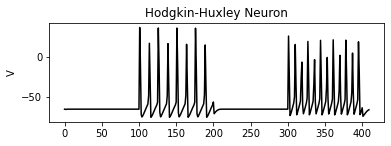

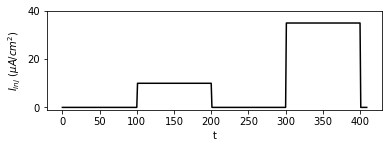

In [3]:
#1. Initialize an hh neuron using the class definition above
hh_neuron = HodgkinHuxley(0.1, 120, 36, 0.3, 50, -77, -54.4, 410, 1) # C_m, g_Na, g_K, g_L, E_Na, E_K, E_L, T, dt

#2. Run the hh neuron simulation
hh_neuron.run()

## 1c. 
The beauty of a neurophysiologically accurate model of a neuron is that it allows the simulation of several phenomena that can take place in the brain. Assume that you administer a drug named Tetrodotoxin (TTX), which is a potent neurotoxin that inhibits the voltage-gated sodium channels, and therefore decreases the sodium current. Simulate the effects that administering TTX would have on the neural firing.  Do the same for another drug, pronase,
which eliminates sodium inactivation. 

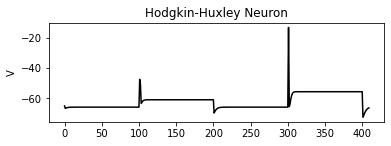

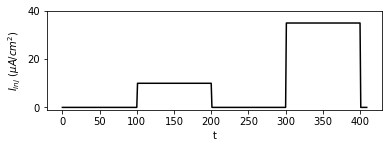

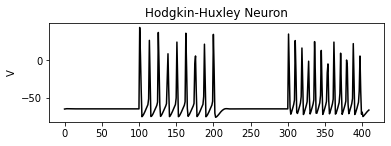

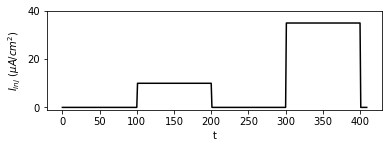

In [4]:
#1. Initialize an hh neuron to simulate TTX
hh_ttx_neuron = HodgkinHuxley(0.1, 0.1*120, 36, 0.3, 50, -77, -54.4, 410, 1) # C_m, g_Na, g_K, g_L, E_Na, E_K, E_L, T, dt

#2. Run the hh neuron simulation
hh_ttx_neuron.run()

#3. Initialize an hh neuron to simulate pronase
hh_pronase_neuron = HodgkinHuxley(0.3, 1.2*120, 36, 0.3, 50, -77, -54.4, 410, 1) # C_m, g_Na, g_K, g_L, E_Na, E_K, E_L, T, dt

#4. Run the hh neuron simulation
hh_pronase_neuron.run()

# Question 2: The Izhikevich Neuron

## 2a.
We will now implement an Izhikevich (Izhi) neuron model. Below is the class definition of an Izhi neuron. Like before, your task is to fill in the different components required to simulate an Izhi neuron. You should notice one key difference in the implementation: While our HH implementation relied on the odeint libary from scipy for integration, here we will use 'Euler's method' to integrate. The Euler's method is very intuitive, simple, and can be easily implemented. For your reference, the dynamics of an Izhi neuron are described in equations 1, 2, 3 in the paper: https://www.izhikevich.org/publications/spikes.pdf

In [5]:
class Izhi():
    """Implementation of the Izhikevich neuron Model"""
    def __init__(self, a, b, c, d, Vth, T, dt):
        """
        :param a, b, c, d: Izhi neuron parameters
        :param Vth: Voltage threshold for spiking
        :param T: Simulation timesteps
        :param dt: Integration time 
        
        This function is complete. You do not need to do anything here.
        """
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.Vth = Vth
        self.u = self.b * self.c #initialize u
        self.T = T
        self.dt = dt
        self.t = np.arange(0, self.T, self.dt)
        self.I = 10 #Input stimulus current
        
    def run(self):
        """
        Main function to simulate Izhi neuron and plot voltage and current against time. Fill in the update equations for du, dv, v[t] and u[t] and resetting on spiking.
        """
        V = np.zeros(len(self.t)) #Initialize a numpy array containing the membrane voltages for all the timesteps
        V[0] = self.c #Initial membrane voltage is the rest potential, defined by the parameter 'c'
        u = np.zeros(len(self.t)) #Initialize a numpy array containing u for all the timesteps
        u[0] = self.u #Initial u
        
        for t in range(1, len(self.t)): #the time loop for performing euler's integration
            dv =  (0.04 * V[t-1]**2) + (5 * V[t-1]) + 140 - u[t-1] + self.I
            du =   self.a * ((self.b * V[t-1]) - u[t-1])
            V[t] =  V[t-1] + dv
            u[t] =  u[t-1] + du
            
            #condition for when membrane potential is greater than the threshold
            if V[t] >= self.Vth:
                V[t] =  self.c
                u[t] =  u[t] + self.d
                
        #plotting
        """This function is complete. You do not need to do anything here"""
        plt.figure()
        plt.subplot(2,1,1)
        plt.title('Izhi Neuron')
        plt.plot(self.t, V, 'k')
        plt.ylabel('V')
        
        plt.figure()
        plt.subplot(2,1,2)
        i_inj = [self.I for t in self.t]
        plt.plot(self.t, i_inj, 'k')
        plt.xlabel('t')
        plt.ylabel('$I_{inj}$ ($\\mu{A}/cm^2$)')
        
        plt.show()

## 2b. 
Initialize an Izhi neuron with the correct parameters and run the simulation. You should again be able to get a plot depicting how the Voltage and Current of the neuron change with time. 

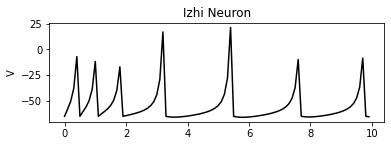

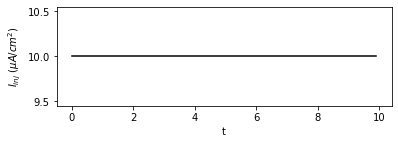

In [6]:
#1. Initialize an izhikevich neuron with the appropriate parameters
izhi_neuron = Izhi(0.02, 0.2, -65, 2, 30, 10, 0.1)    # a, b, c, d, Vth, T, dt

#2. Run the simulation and obtain the results
izhi_neuron.run()

## 2c.
Change the parameters of the Izhi neuron in the code to replicate two different patterns identified in neurons, e.g., bursting and adaptation. You can find the parameters for several different Izhi models here: https://www.izhikevich.org/publications/spikes.pdf

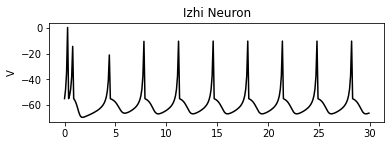

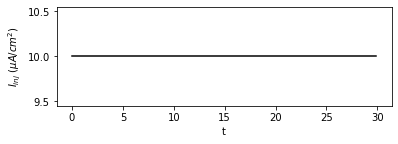

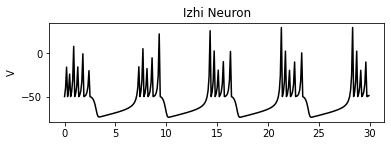

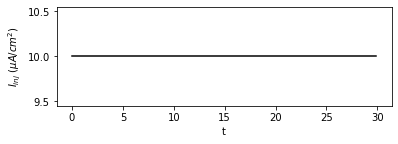

In [7]:
#Write your implementation of the bursting and chattering neuron here

#1. Initialize an izhikevich neuron with the appropriate parameters
izhi_burst_neuron = Izhi(0.02, 0.2, -55, 4, 30, 30, 0.1)    # a, b, c, d, Vth, T, dt
izhi_chatter_neuron = Izhi(0.02, 0.2, -50, 2, 30, 30, 0.1)    # a, b, c, d, Vth, T, dt

#2. Run the simulation and obtain the results
izhi_burst_neuron.run()
izhi_chatter_neuron.run()

# Question 3: The LIF Neuron

## 3a. 
In this question, you will implement the almighty leaky integrate and fire neuron (LIF). The LIF neuron is the most widely-used model of a neuron in the SNN literature and you will be using it a lot for your course assignments and for your project. Below is the class definition of an LIF neuron. Just like the Izhi neuron, we will use Euler's method to perform integration. There is one key difference however: For HH and Izhi implementations, the neuron was taking current as the input. In our LIF implementation, the neuron takes spike-trains as inputs and produces spike-trains as output, similarly to how a real neuron works. 

As a hint, we provide here a discrete-time version of an LIF neuron:

* First, integrate the input spikes into current with some decay factor

$$C[t] = C[t-1] * current\_decay + input\_spike[t]$$

* Then, integrate the current  into voltage with some decay factor

$$V[t] = V[t-1] * voltage\_decay + C[t]$$

* Lastly produce a spike if the voltage exceeds the threshold, and reset voltage

$$if V[t] >= Vth  \\ output\_spike[t] = 1 \ and \ V[t] = Rest\_Potential $$

In [8]:
class LIF():
    """Implementation of Leaky integrate and fire neuron Model"""
    def __init__(self, dc, dv, Vth, Vr):
        """
        :param dc: Decay factor for current
        :param dv: Decay factor for voltage
        :param Vth: Voltage Threshold
        :param Vr: Rest potential 
        
        This function is complete. You do not need to do anything here
        """
        self.dc = dc
        self.dv = dv
        self.Vth = Vth
        self.Vr = Vr
    
    def run(self, in_spikes):
        """
        Main function to simulate LIF neuron
        :param in_spikes: Input spike train
        :return out_spikes: output spike train
        
        Fill in the parts for updating Cm, Vm, and the condition for spiking and resetting
        """
        Vm, Cm, out_spikes = [np.zeros(len(in_spikes)) for _ in range(3)] #initialize the state variables
        for t in range(1, len(in_spikes)): #Time loop to perform Euler's Integration
            Cm[t] =  Cm[t-1]*self.dc + in_spikes[t]
            Vm[t] =  Vm[t-1]*self.dv + Cm[t]
            
            #condition for when membrane potential is greater than the threshold
            if Vm[t] >= self.Vth:
                out_spikes[t] = 1
                Vm[t] = self.Vr

        return out_spikes

## 3b. 
Based on the class definition above, create an LIF neuron with the following parameters: dc = 0.5, dv = 0.5, Vth = 0.50, Vr = 0. 
Then apply to the neuron a random spike train for 15 timesteps. You might find the following numpy package useful to generate the input spike train:
https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html

Simulate the neuron and print input and output spikes. 

In [9]:
#1. Create an LIF neuron with the required parameters using the class definition above
lif = LIF(0.5, 0.5, 0.50, 0)     # dc, dv, Vth, Vr

#2. Generate a random input spike train of 15 timesteps using the numpy random choice library function
in_spikes = np.random.choice([0,1], 15, p = [0.6, 0.4])

#3. Print the input spikes
print("Input spikes passed to LIF neuron: {}".format(in_spikes))

#4. Stimulate the LIF neuron with input spikes and return the output spikes
out_spikes = lif.run(in_spikes)

#5. Print the output spikes
print("Output spikes received from LIF neuron: {}".format(out_spikes))

Input spikes passed to LIF neuron: [0 1 0 0 1 0 1 0 0 0 0 1 1 0 0]
Output spikes received from LIF neuron: [0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0.]


# Question 4: Biology vs. Efficiency
Now that you have simulated spiking neuron models at different levels of abstraction, we will learn how to differentiate between the three neuron models that we have developed, based on the following criteria:
* Biological realism
* Computational Efficiency

Can you describe for what tasks might you need an HH model? For what tasks would an LIF neuron be a better alternative?
*Hint*: Why one should use a neuron model that replicates several of the neuron's mechanisms vs. using a model that emulates the neuron as a spike-in-spike-out black box. 

## Answer 4:
> * **Hodgkin-Huxley** is not very computationally efficient but it mimics biological neurons very closely (high biological plausibility). We can use H-H model when we need to simulate several phenomena that can take place in the brain.<br>
> * The **LIF** model is too simple to reproduce diversity of dynamical features of biological neurons, however they are computationally very efficient and can be analyzed mathematically in great detail. With LIF, it is possible to simulate very large networks of neurons and hence we implement LIF when we need to work with multiple neurons, like when predicting some complex decision/value given an input stimuli/current/spike.<br>
> * The **Izhikevich** neuron takes the best from both H-H and LIF models. They are both mathematically tractable and can simulate dynamic behaviors of real neurons as H-H type models.

# Question 5: Tuning Membrane Properties of the LIF neuron
## 5a.
In this question, you will understand how to tune the membrane properties of an LIF neuron. First, generate 20 inputs in the form of random spike trains of length 50, i.e. 50 timesteps. The inputs will have different levels of probabilities for spike generation, that ranges between 0.1 and 1.0 with step size of 0.05. In other words, you will create 20 spike trains with the first spike train having the probability of 0.1 to generate spikes at any timestep, the second spike train will have the spike generation probability of 0.15, and so on. 

Simulate an LIF neuron with the parameters defined in Question 3b. You will now drive the neuron model with the 20 randomly generated input spike trains that you have created, and compute the output spike train. 
At the same time, compute the input firing rate and output firing rate for each simulation. Firing rate is defined as the mean of the spike train, i.e. total number of spikes/timesteps

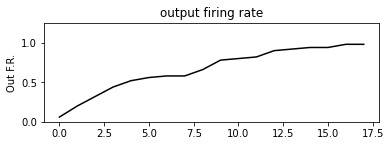

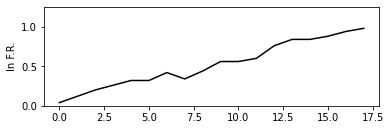

In [10]:
def lif_behavior(lif):
    """Function to understand the behavior of LIF neuron for different densities of spike inputs
    :param lif: An instance of the LIF neuron
    """
    #1. Create lists to store the input and output firing rates
    in_fr = [] #input firing rate
    out_fr = [] #output firing rate
    
    #2. Create a list of probabilities: from 0.1 to 1.0 with step size of 0.05. You might find the numpy arange function helpful here.
    probabilities = np.arange(0.1, 1, 0.05)
    
    #3. Loop through the range of probabilities
    for p in probabilities:
        in_spikes =  np.random.choice([0,1], 50, True, [1-p, p])
        
        #compute input firing rate and append to the in_fr list
        in_fr.append(sum(in_spikes)/len(in_spikes))
        
        #obtain output spikes by applying the input to the LIF neuron
        out_spikes = lif.run(in_spikes)
        
        #compute output firing rate and append to the out_fr list
        out_fr.append(sum(out_spikes)/len(out_spikes))
        # print("p:{}\nInput Spikes:{}\nOutput Spikes:{}".format(p,in_spikes, out_spikes))
    #Plot the input and output firing rates. Nothing to do here. This part is complete
    plt.figure()
    plt.subplot(2,1,1)
    plt.title('output firing rate')
    plt.plot(out_fr, 'k')
    plt.ylabel('Out F.R.')
    plt.ylim([0,1.25])

    plt.figure()
    plt.subplot(2,1,2)
    plt.plot(in_fr, 'k')
    plt.ylabel('In F.R.')
    plt.ylim([0,1.25])
    plt.show()

#Run the lif behavior function for the LIF neuron that we created previously
lif_behavior(lif)

## 5b. 
Describe how soon does the output firing rate start to saturate? Can you describe why this could be problematic? *Hint: Think from the point of view of distinguishing between two different inputs based on firing activity*

## Answer 5b.
>We observe here that for every continuous spike (1) in *in_spikes* [0 1 0 0 1 1 0], we get one extra spike (1) in *out_spikes* [0 1 1 0 1 1 1]. This essentially means that as we increase the probability of a spike (1) in *in_spikes*, we will eventually reach a probability after which we start getting *in_spikes* such that **output firing rate** saturates. This is problematic because after a certain point, we won't be able to differentiate between different input spikes as all of them will have same output firing rate, leading to more error and ambiguity.

><br>Consider below examples:

>1. in_spikes = [0 1 1 0 1 1 0], out_spikes = [0 1 1 1 1 1 1]

>2. in_spikes = [0 1 1 1 1 1 0], out_spikes = [0 1 1 1 1 1 1]

>3. in_spikes = [0 1 1 1 1 1 1], out_spikes = [0 1 1 1 1 1 1]

><br>This behaviour depends extensively on voltage calculation, $$V[t] = V[t-1] * voltage\_decay + C[t]$$ 
which in turn depends on current value *C[t]* $$C[t] = C[t-1] * current\_decay + input\_spike[t]$$ 
We also observe that as soon as **V[t] >= Vth** we get one output spike and voltage is reset to or decays to resting potential, i.e, 0 immediately. This indicates that *C[t]* plays a major role in taking the value of *V[t]* above or equal to *Vth*. Thus, if we decay the current at a more faster rate, we can deal with the issue of output_rate saturation, which then will more closely mimic the *in_spikes*. To decay the current more quickly, we decrease the value of current_decay in above calculation for *C[t]*. We can also try increasing **Vth** slightly, which restricts the extra output_spike *(though we need to be careful that we don't increase it too much, else out_spikes might not fire correctly)*.

## 5c. 
Change the membrane properties of the LIF neuron to resolve the issue of saturation. In other words, experiment on setting different parameter values that do not allow the output firing rate to saturate so early. *Hint: You may want to start by changing one variable at a time, and see its effect. Try to move it slightly, or abruptly, up or down. Then move to the next parameter, until you see what is its effect on the neuron's output.* 

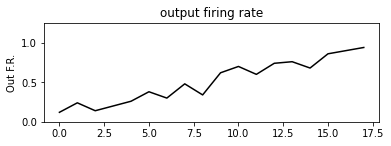

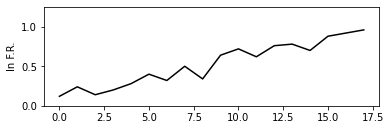

In [11]:
#1. Create an LIF neuron with appropriately tuned membrane properties
tuned_lif = LIF(0.20, 0.5, 0.50, 0)     # dc, dv, Vth, Vr

#2. Call the lif behavior function on the tuned lif neuron
lif_behavior(tuned_lif)

## 5d.
Based on the above results, can you describe how changing the H-H parameters changes the voltage threshold of a spiking neuron as a function of the input spikes?

## Answer 5d.
>H-H model can be used to model the total current resulting from an applied voltage, furthermore, the model can also be used to predict voltage given an externally applied current. If we consider the input spikes in LIF model as externally applied current to H-H model, we can have dynamic voltage threshold as a function of input spikes.

# Question 6: Encoding continuous inputs into spikes
## 6a.
Now we will understand how we can represent continuous-valued inputs as spikes so that drive our spiking neuron. Describe two prominent ways to encode a continuous-valued input into the spiking activity of a neuron. 

## Answer 6a.
>Two prominent ways to encode a continuous-values input into the spiking activity of neuron are:

>1. **Rate Coding**, converts input intensity into a firing rate or spike count. Rate coding models suggest that the irregularities of neuronal firing are noise and average them.
>2. **Temporal Coding**, converts input intensity to a spike time. Temporal code models assume that precise timing of spikes and interspike intervals carries information.

## 6b. 
So far we have learned how we can stimulate a spiking neuron using spike inputs. In this exercise, you will learn how to encode real-world data into spikes that can then be fed as inputs to the spiking neuron. We will take a digit from the popular MNIST dataset as an example. First let's see what a sample digit from the MNIST image looks like. For this, we need to create a loader for the MNIST dataset using a Pytorch function called datasets.MNIST. You do not need to know what a loader is for now. Just understand the two important arguments of the function: The first argument is the directory where the MNIST dataset will be downloaded. The third argument is the set download option. This should be true for the first time when you run this cell to allow you to download the MNIST data into your directory. You can set it to false if the MNIST data has already been downloaded. 

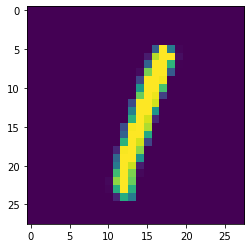

In [12]:
#Create a loader
mnist = datasets.MNIST(root='../data', train=False, download=False, transform=transforms.ToTensor())
#You can access any sample digit from the MNIST dataset using simple indexing mnist[idx]. This returns the digit and the label. We are only interested in the digit. 
x, _ = mnist[5]
#Convert to numpy
x = x.numpy()[0]
#Visualize
plt.imshow(x)

Let's now encode the image in the form of spikes using rate-encoding. Suppose that each pixel in the image needs to be encoded in a spike train of length 2. The steps to encode are outlined below:
* For each pixel in the image, sample a random number.
* If the pixel intensity is greater than the generated random number, output a spike. 
* Repeat for as many timesteps as you need to encode the image for. 
* Repeat for all pixels

In [13]:
#1. Use the numpy.random.rand function to encode the MNIST image into spikes
def encode(in_img, T):
    rows, cols = in_img.shape
    ran_px_prob = np.random.rand(rows*cols, T) # generate random values for T timesteps
    img_comp = np.transpose([in_img.flatten()]*T) # flatten image array and make a copy into T columns
    in_spikes = img_comp > ran_px_prob # create spikes for T time steps by comparing image pixels with randomly generated value

    return in_spikes

#2. Output the shape of the spike-encoded image using numpy.shape
in_spikes = encode(x, T = 2)
print("Encoded Image Shape: {}".format(in_spikes.shape))

Encoded Image Shape: (784, 2)


## 6c. 
Now, we will decode the image back from the spike-based representation. Can you think of a way to get the pixel values back? *Hint: Think aggregate measures on the spike trains for each pixel*

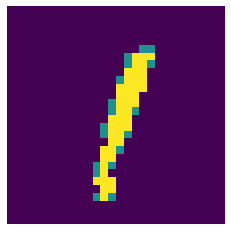

In [14]:
#1. Compute some aggregate measure of spike trains for each pixel to get the image back. Numpy aggregate functions might be useful here
def decode(in_spikes, shape):
    out_img = np.mean(in_spikes, axis = 1).reshape(shape)

    return out_img

#2. visualize the reconstructed image
out_img = decode(in_spikes, shape = x.shape)
plt.imshow(out_img)
plt.axis('off')
plt.show()

Is it possible to get the exact image back? Why/Why not?

## Answer 6c.
>It is not possible to get the exact image back. We will face some loss in terms of pixel intensities or some loss of pixels itself. However, if we use sufficient enough time steps or multiple neurons (population encoding) to represent firing rate of each pixel in input image, we can reconstruct a very similar image in which the change would not be noticable.

## 6d. 
Can you think of a way to encode the image into spikes in a way such that the decoded image looks as close as possible to the original image? *Hint: Think timesteps*

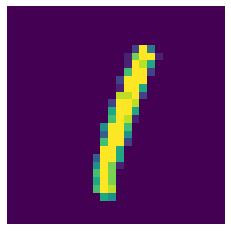

In [15]:
#1. Create a "better" encoding of the image
in_tuned_spikes = encode(x, T = 10)

#2. Compute and visualize the decoded image
out_tuned_img = decode(in_tuned_spikes, shape = x.shape)
plt.imshow(out_tuned_img)
plt.axis('off')
plt.show()

If each intensity pixel is represented with a value between [0, 255], what would be a reasonable timestep to encode it accurately? What might be a disadvantage of this solution?

## Answer 6d. 
>We can use 8 timesteps to represent pixel values between [0, 255], as we can represent 256 values in terms of 8-bits, 2<sup>8</sup>, The only disadvantage is that we will face some loss of information in terms of pixel intensity.